In [15]:
!pip install torch numpy pandas


import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt



# Function to create the rotation matrix for RoPE embeddings
def generate_rotation_matrix(seq_length, embed_dim):
    theta = np.arange(embed_dim // 2) / (embed_dim // 2)
    theta = 1.0 / (10000 ** theta)
    pos = np.arange(seq_length)
    pos_theta = np.outer(pos, theta)
    cos_pos_theta = np.cos(pos_theta)
    sin_pos_theta = np.sin(pos_theta)

    rotation_matrix = np.zeros((seq_length, embed_dim))
    rotation_matrix[:, 0::2] = cos_pos_theta
    rotation_matrix[:, 1::2] = sin_pos_theta

    return rotation_matrix

In [16]:
# Custom RMS Normalization layer
class RMSNorm(nn.Module):
    def __init__(self, layer_dims, epsilon=1e-8):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(layer_dims))
        self.epsilon = epsilon

    def forward(self, tensor_input):
        norm = tensor_input.norm(2, dim=-1, keepdim=True)
        rms = norm / (tensor_input.size(-1) ** 0.5)
        return tensor_input / (rms + self.epsilon) * self.gamma

In [17]:
# Attention head with RoPE embeddings and masking
class AttentionHeadWithRoPE(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        self.query = nn.Linear(params['embedding_size'], params['embedding_size'], bias=False)
        self.key = nn.Linear(params['embedding_size'], params['embedding_size'], bias=False)
        self.value = nn.Linear(params['embedding_size'], params['embedding_size'], bias=False)
        self.rotation_matrix = torch.tensor(generate_rotation_matrix(params['sequence_length'], params['embedding_size']), dtype=torch.float32).to(params['device'])

    def forward(self, data_input, return_attention=False):
        batch_size, seq_len, embed_dim = data_input.shape
        queries = self.query(data_input)
        keys = self.key(data_input)
        values = self.value(data_input)

        queries = torch.einsum('bse,se->bse', queries, self.rotation_matrix)
        keys = torch.einsum('bse,se->bse', keys, self.rotation_matrix)

        attention_scores = torch.einsum('bse,bte->bst', queries, keys) / (embed_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)

        attention_output = torch.einsum('bst,bte->bse', attention_weights, values)
        return attention_output

In [18]:
# Multi-head attention module
class MultiHeadAttention(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        self.attention_heads = nn.ModuleList([AttentionHeadWithRoPE(params) for _ in range(params['attention_heads'])])
        self.output_linear = nn.Linear(params['embedding_size'] * params['attention_heads'], params['embedding_size'])
        self.dropout = nn.Dropout(params['dropout'])

    def forward(self, data_input):
        head_outputs = [head(data_input) for head in self.attention_heads]
        concatenated_output = torch.cat(head_outputs, dim=-1)
        output = self.output_linear(concatenated_output)
        output = self.dropout(output)
        return output

In [19]:

# Swish-Gated Linear Unit (SiGLU) activation function
class SwishGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = nn.Parameter(torch.ones(1))

    def forward(self, data_input):
        gate_output = self.linear_gate(data_input)
        linear_output = self.linear(data_input)
        return linear_output * torch.sigmoid(self.beta * gate_output)

In [20]:
# Transformer block consisting of attention and feedforward layers
class LLamaBlock(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.norm1 = RMSNorm(params['embedding_size'])
        self.attention = MultiHeadAttention(params)
        self.norm2 = RMSNorm(params['embedding_size'])
        self.feedforward = nn.Sequential(
            nn.Linear(params['embedding_size'], params['embedding_size']),
            SwishGLU(params['embedding_size']),
            nn.Linear(params['embedding_size'], params['embedding_size'])
        )

    def forward(self, data_input):
        data_input = data_input + self.attention(self.norm1(data_input))
        data_input = data_input + self.feedforward(self.norm2(data_input))
        return data_input

In [21]:
# LLaMA-like language model
class LLama(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        self.embedding = nn.Embedding(params['vocab_size'], params['embedding_size'])
        self.blocks = nn.Sequential(OrderedDict([
            (f"block_{i}", LLamaBlock(params)) for i in range(params['transformer_blocks'])
        ]))
        self.norm = RMSNorm(params['embedding_size'])
        self.output_linear = nn.Linear(params['embedding_size'], params['vocab_size'])

        print("Model parameters:", sum([p.numel() for p in self.parameters()]))

    def forward(self, input_ids, target_ids=None):
        embeddings = self.embedding(input_ids)
        data_output = self.blocks(embeddings)
        data_output = self.norm(data_output)
        logits = self.output_linear(data_output)

        if target_ids is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target_ids.view(-1))
            return logits, loss

        return logits, None

In [22]:
# Data preprocessing function
def prepare_data(file_path):
    with open(file_path, 'r') as file:
        text = file.read()

    chars = list(set(text))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}

    data_tensor = torch.tensor([char_to_idx[ch] for ch in text], dtype=torch.long)
    return data_tensor, len(chars)

# Function to create training batches
def batch_generator(data, split, batch_size, seq_len, params):
    data_size = len(data)
    if split == "train":
        data = data[:int(0.8 * data_size)]
    elif split == "validation":
        data = data[int(0.8 * data_size):int(0.9 * data_size)]
    else:
        data = data[int(0.9 * data_size):]

    total_batches = len(data) // (batch_size * seq_len)
    input_sequences = []
    target_sequences = []

    for _ in range(batch_size):
        start_idx = np.random.randint(0, len(data) - seq_len - 1)
        input_seq = data[start_idx:start_idx + seq_len]
        target_seq = data[start_idx + 1:start_idx + seq_len + 1]
        input_sequences.append(input_seq)
        target_sequences.append(target_seq)

    return torch.stack(input_sequences), torch.stack(target_sequences)

In [23]:
# Function to evaluate model loss
@torch.no_grad()
def eval_loss(model, dataset, params):
    results = {}
    model.eval()
    for split in ["train", "validation"]:
        batch_losses = []
        for _ in range(10):
            input_batch, target_batch = batch_generator(dataset, split, params['training_batch'], params['sequence_length'], params)
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            _, batch_loss = model(input_batch, target_batch)
            batch_losses.append(batch_loss.item())
        results[split] = np.mean(batch_losses)
    model.train()
    return results

In [24]:
# Training loop
import time
def train_model(model, optimizer, dataset, params, scheduler=None):
    all_losses = []
    start = time.time()
    for epoch in range(params['training_epochs']):
        optimizer.zero_grad()
        input_batch, target_batch = batch_generator(dataset, 'train', params['training_batch'], params['sequence_length'], params)

        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        _, batch_loss = model(input_batch, target_batch)
        batch_loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if (epoch + 1) % params['logging_frequency'] == 0:
            time_elapsed = time.time() - start
            evaluation_result = eval_loss(model, dataset, params)
            all_losses.append(evaluation_result)
            print(
                f"Epoch {epoch + 1}/{params['training_epochs']} | "
                f"Validation Loss: {evaluation_result['validation']:.4f} | "
                f"Time: {time_elapsed:.2f}s"
            )
            start = time.time()
            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("Final Validation Loss: ", all_losses[-1]['validation'])
    return pd.DataFrame(all_losses).plot()

GPU not found, using CPU for training.
Model parameters: 3567841
Epoch 10/100 | Validation Loss: 3.2463 | Time: 36.13s
Epoch 20/100 | Validation Loss: 3.0020 | Time: 34.98s
Epoch 30/100 | Validation Loss: 2.6842 | Time: 34.65s
Epoch 40/100 | Validation Loss: 1.9638 | Time: 34.69s
Epoch 50/100 | Validation Loss: 1.2374 | Time: 33.98s
Epoch 60/100 | Validation Loss: 0.7953 | Time: 36.06s
Epoch 70/100 | Validation Loss: 0.5447 | Time: 34.80s
Epoch 80/100 | Validation Loss: 0.3860 | Time: 34.41s
Epoch 90/100 | Validation Loss: 0.3157 | Time: 33.58s
Epoch 100/100 | Validation Loss: 0.2475 | Time: 34.35s
Final Validation Loss:  0.24753210544586182


<Axes: >

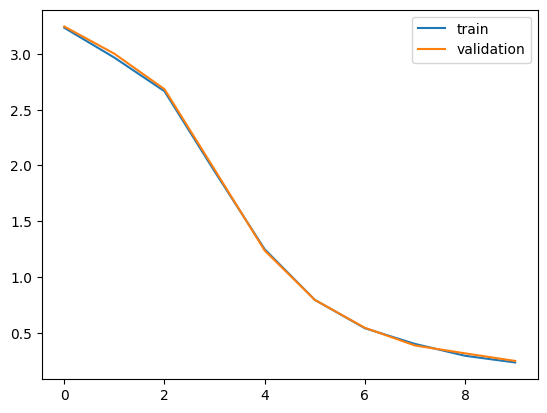

In [25]:
# Load and process the dataset
# Check GPU availability and set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU for training.")
else:
    device = torch.device('cpu')
    print("GPU not found, using CPU for training.")
# Load and process the dataset
data_path = "/content/input.txt"
dataset, vocab_size = prepare_data(data_path)

# Configuration for the language model
MODEL_PARAMS = {
    'vocab_size': vocab_size,
    'embedding_size': 128,
    'attention_heads': 8,
    'sequence_length': 64,
    'transformer_blocks': 6,
    'training_batch': 64,
    'training_epochs': 100,
    'logging_frequency': 10,
    'dropout': 0.1,
    'device': device
}



# Create the language model
if torch.cuda.device_count() > 1:
    print(f"Distributing training across {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(LLama(MODEL_PARAMS)).to(device)
else:
    model = LLama(MODEL_PARAMS).to(device)

# Move the dataset to the selected device
dataset = dataset.to(device)

# Create the optimizer
optimizer = torch.optim.Adam(model.parameters())

# Start training
train_model(model, optimizer, dataset, MODEL_PARAMS)
